# Clustering Experiments

In [1]:
%run Detector.ipynb

In [2]:
from collections import defaultdict
import plotly.express as px
import seaborn as sns
import pandas as pd
import os
import re

import warnings
warnings.filterwarnings('ignore')

In [3]:
DATA_FOLDER = 'data'
OUTP_FOLDER = 'outputs'

In [4]:
def get_files_like(file_name_pattern=r'(?s).*', folder=DATA_FOLDER):
    file_names = []
    for file_name in os.listdir(folder):
        if re.search(file_name_pattern, file_name):
            file_names.append(os.path.join(folder, file_name))
    return file_names
                
def load_data_from(file_names, **kwargs):
    data = []
    if type(file_names) == str:
        return pd.read_csv(file_names, **kwargs)
    else:
        for file_name in file_names:
            data.append(pd.read_csv(file_name, **kwargs))      
    return data[0] if len(data) == 1 else data

def key_formatter(name):
    return name.split('_')[-1].split('.')[0]

def run_experiments(locations, kernels, clusters, verbose=True, *args, **kwargs):
    detectors = defaultdict(dict)
    for c in clusters:
        for n, k in kernels.items():
            detectors[c][n] = Detector(k, locations, as_df=True, n_clusters=c, *args, **kwargs).run()
        if verbose:
            print('Completed cluster:', c)
    return detectors

In [5]:
stp_loc = load_data_from(get_files_like('stp'))
kernels = {
    key_formatter(f) : load_data_from(f, header=None) for f in get_files_like('kernel')
}

In [20]:
stp_loc

lon       lat  pop
0    7.429170  1.619300  222
1    7.414210  1.634090   12
2    7.413900  1.636020    8
3    7.412190  1.634920   16
4    7.425910  1.640410   23
..        ...       ...  ...
504  6.504663  0.278204   20
505  6.511289  0.300431   20
506  6.520465  0.300532   74
507  6.571916  0.303792   20
508  6.562708  0.313705    9

[509 rows x 3 columns]

In [6]:
# Specify clusters to use below:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 150, 200, 250, 300]

In [7]:
results = run_experiments(stp_loc, kernels, clusters)
results

Completed cluster: 2
Completed cluster: 3
Completed cluster: 4
Completed cluster: 5
Completed cluster: 6
Completed cluster: 7
Completed cluster: 8
Completed cluster: 9
Completed cluster: 10
Completed cluster: 50
Completed cluster: 100
Completed cluster: 150
Completed cluster: 200
Completed cluster: 250
Completed cluster: 300


defaultdict(dict,
            {2: {'10k': <__main__.Detector at 0x1cc59f3c848>,
              '2500': <__main__.Detector at 0x1cc59f2a388>,
              '5000': <__main__.Detector at 0x1cc5926be08>,
              '7500': <__main__.Detector at 0x1cc59f913c8>},
             3: {'10k': <__main__.Detector at 0x1cc59f97608>,
              '2500': <__main__.Detector at 0x1cc59f976c8>,
              '5000': <__main__.Detector at 0x1cc5a2032c8>,
              '7500': <__main__.Detector at 0x1cc5a203088>},
             4: {'10k': <__main__.Detector at 0x1cc5a20abc8>,
              '2500': <__main__.Detector at 0x1cc5a212f48>,
              '5000': <__main__.Detector at 0x1cc5a214888>,
              '7500': <__main__.Detector at 0x1cc5a202948>},
             5: {'10k': <__main__.Detector at 0x1cc5a226088>,
              '2500': <__main__.Detector at 0x1cc5a225f08>,
              '5000': <__main__.Detector at 0x1cc5a21b888>,
              '7500': <__main__.Detector at 0x1cc5a225848>},
          

# Data Visualization

In [8]:
def get_label_counts(results, cluster_num, kernel_names=None):
    df = pd.DataFrame()
    names = results[cluster_num].keys() if kernel_names is None else kernel_names
    for name in names:
        d = results[cluster_num][name]
        counts = d.results().groupby('type').size().to_frame().rename(columns={0 : "count"})
        if 'bridge' not in counts.index:
            counts = counts.append(pd.DataFrame([0], index=['bridge'], columns=['count']))
        if 'sink'   not in counts.index:
            counts = counts.append(pd.DataFrame([0], index=['sink'], columns=['count']))
        if 'source' not in counts.index:
            counts = counts.append(pd.DataFrame([0], index=['source'], columns=['count']))
        counts = pd.concat({name : counts}, names=['name'])
        df = pd.concat([df, counts])
    df['clusters'] = cluster_num
    return df

def get_steps(d, k, start=None, final=None):
    if type(k) != int:
        return k
    elif start is None and final is None:
        return np.round(np.linspace(0, d.ss_step, k)).astype(int)
    elif start is None:
        return np.round(np.linspace(0, final, k)).astype(int)
    elif final is None:
        return np.round(np.linspace(0, d.ss_step, k)).astype(int)
    else:
        return np.round(np.linspace(start, final, k)).astype(int)

def plot_steady_state_progression(results, cluster_num, k=200, start=None, final=None, fs=(8,8)):
    """
    Plots the number of nodes that experienced a population change 
    versus time over `k` evenly spaced values. A custom range may be
    used if `k` is passed in as a list of ints.
    """
    df = pd.DataFrame()
    if final is None: final = np.max([d.ss_step for d in results[cluster_num].values()])
    for n, d in results[cluster_num].items():
        steps = get_steps(d, k, start, final)
        temp = pd.DataFrame()
        temp['count'] = np.sum(~np.isclose(np.diff(np.array([d.migrate(s) for s in steps]), axis=0), 0), axis=1)
        temp['kname'] = n
        temp['steps'] = steps[1:]
        df = pd.concat([df, temp])
    plt.figure(figsize=fs)
    sns.lineplot(x="steps", y="count", hue="kname", data=df)
    plt.title("Steady State Progression")
    plt.xlabel("Time Step")
    plt.ylabel("Number of Migrations")
    
def plot_label_counts(results, cluster_num, fs=(8,6)):
    """
    Plots a side by side bar plot of the sink/bridge/source counts
    for each kernel.
    """
    df = get_label_counts(results, cluster_num).reset_index().rename(columns={'level_1' : 'type'})
    plt.figure(figsize=fs)
    sns.barplot(x="name", y="count", hue="type", data=df)
    plt.title(f"Sink/Bridge/Source Counts for {cluster_num} Cluster(s)")
    plt.xticks(rotation=30);

def plot_interactive_label_counts(results, kernel_name):
    """
    Plots a side by side bar plot of the sink/bridge/source counts
    for `kernel_name` over all clusters.
    """
    df = pd.concat([get_label_counts(results, c, [kernel_name]) for c in results])\
           .reset_index()\
           .rename(columns={'level_1' : 'type'})
    fig = px.bar(df, x="type", y="count", color="type",
      animation_frame="clusters", animation_group="clusters", range_y=[0, df["count"].max()])
    fig.show()
    
def plot_line_label_counts():
    pass
    
def plot_population_distribution(results, cluster_num, kernel_name, k=200, start=None, final=None):
    """
    Plots an interactive visualization of the population for every 
    state from time step `start` to time step `final` over `k` values
    for `kernel_name`. A custom range may be used if `k` is passed in
    as a list of ints.
    """
    d = results[cluster_num][kernel_name]
    steps = get_steps(d, k, start, final)        
    df = pd.DataFrame({
        'node'       : list(range(len(d.tmtx))) * len(steps),
        'population' : np.array([d.migrate(s) for s in steps]).flatten(),
        'step'       : np.array([[s] * len(d.tmtx) for s in steps]).flatten()
    })
    
    fig = px.bar(df, x="node", y="population", color="node",
      animation_frame="step", animation_group="node", range_y=[0, df['population'].max()])
    fig.show()

In [9]:
print(" Kernels:", list(kernels.keys()))
print("Clusters:", clusters)

 Kernels: ['10k', '2500', '5000', '7500']
Clusters: [2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 150, 200, 250, 300]


In [10]:
# Specify a kernel name and a clustering number
KERNEL_NAME = '2500'
CLUSTER_NUM = 300

## Steady State Analysis

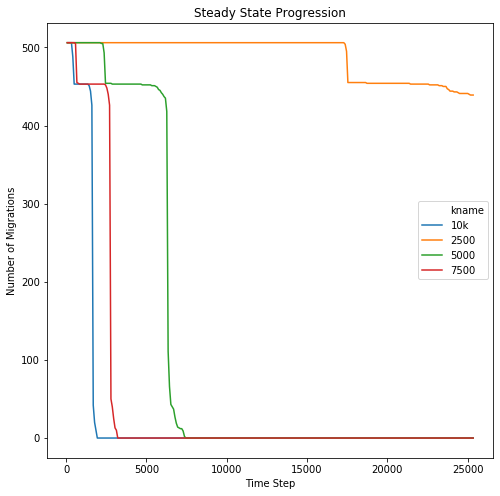

In [11]:
plot_steady_state_progression(results, CLUSTER_NUM, k=300)

In [12]:
custom_range = list(range(81)) + list(range(500, 1000, 50))
plot_population_distribution(results, CLUSTER_NUM, KERNEL_NAME, k=custom_range)

#### Observation(s): 
- The time step at which steady state occurs appears to be longer as kernel number decreases.
- The number of clusters do not interfere with the time step at which steady state occurs.
- The population changes most drastically in the first hundred time steps. Very minor changes in population occur afterwards. This occurs for all combinations of kernels and clusters.
- When the same initial population is used for all kernels, each kernel reaches the same steady state distribution.

## Sink/Source/Bridge Analysis

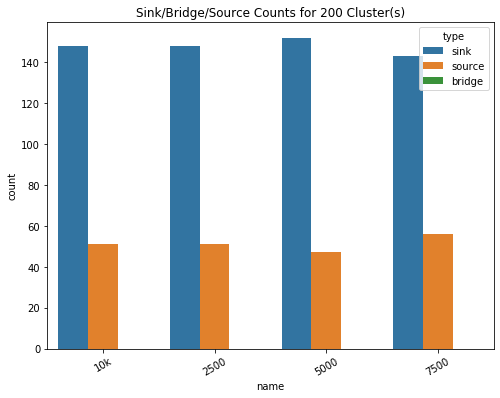

In [23]:
plot_label_counts(results, 200)

In [14]:
plot_interactive_label_counts(results, KERNEL_NAME)

#### Observation(s): 
- Assuming all kernels have reached steady state, there appears to be no variation among the number of sinks, sources, and bridges for each of the kernels.
- The number of sinks and sources increase as the number of clusters increases. 

# Network Plots

In [15]:
import geojson
from descartes import PolygonPatch

# To plot a background, convert the SHP file(s) to a geojson file
# Use: https://mygeodata.cloud/converter/shp-to-geojson
with open("STP.geojson") as json_file:
    json_data = geojson.load(json_file)

poly = json_data['features']

In [16]:
# Retrieves the polygon coordinates for the background 
principe = { 'type' : 'MultiPolygon', 'coordinates' : poly[0]['geometry']['coordinates'] }
sao_tome = { 'type' : 'MultiPolygon', 'coordinates' : poly[1]['geometry']['coordinates'] }
all_data = { 'type' : 'MultiPolygon', 'coordinates' : poly[0]['geometry']['coordinates'][:] }
all_data['coordinates'].extend(poly[1]['geometry']['coordinates'][:])

In [17]:
d = results[CLUSTER_NUM][KERNEL_NAME]
cids = d.clabels()
prps = d.results()

principe_locs = cids[cids['lat'] > 1.25]
principe_tmtx = kernels[KERNEL_NAME].iloc[principe_locs.index, principe_locs.index]
principe_coms = prps[prps.index.isin(principe_locs['cid'].unique())]

sao_tome_locs = cids[cids['lat'] < 0.50]
sao_tome_tmtx = kernels[KERNEL_NAME].iloc[sao_tome_locs.index, sao_tome_locs.index]
sao_tome_coms = prps[prps.index.isin(sao_tome_locs['cid'].unique())]

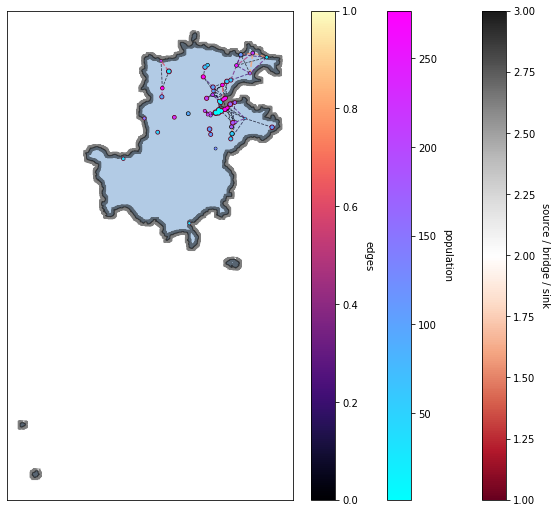

In [24]:
plot_data(principe_tmtx, principe_locs, principe_coms,\
          nodes_fn=lambda x: x**(1/3),
          bordr_mu=3,
          min_prob=0.007,
          edges_mu=100,
          bgrd_crd=principe,
          bgbd_lwd=5,
          fig_size=(10,9),
          plt_bbar=True,
          plt_pbar=True,
          plt_sbar=True
)

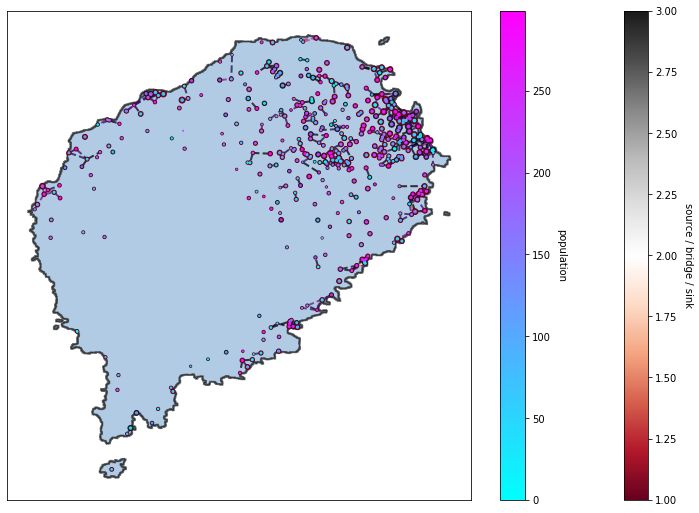

In [19]:
plot_data(sao_tome_tmtx, sao_tome_locs, sao_tome_coms,\
          nodes_fn=lambda x: x**(1/4),
          bordr_mu=5,
          edges_fn=np.log10,
          min_prob=0.009,
          edges_mu=1,
          bgrd_crd=sao_tome,
          bgbd_lwd=2,
          fig_size=(13,9),
          plt_bbar=True,
          plt_pbar=True,
#           plt_sbar=True,
)